<a href="https://colab.research.google.com/github/jimimased/multimodal_rag_pipeline/blob/main/multimodal_rag_pipeline/notebooks/artistic_style_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Artistic Styles with Multimodal RAG Pipeline

This notebook demonstrates how to use the Multimodal RAG Pipeline for analyzing artistic styles in images, similar to the approach described in the [Hugging Face cookbook article on analyzing art](https://huggingface.co/learn/cookbook/en/analyzing_art_with_hf_and_fiftyone).

We'll cover:
1. Setting up the environment
2. Loading a collection of artwork images (from web or Google Drive)
3. Analyzing artistic styles using multimodal embeddings
4. Creating a style similarity matrix
5. Visualizing style relationships
6. Using style analysis in a RAG context

## 1. Setup

First, let's set up the environment and install the necessary dependencies.

In [1]:
#!pip install git+https://github.com/jimimased/multimodal_rag_pipeline.git
#!pip install clip torch torchvision matplotlib seaborn scikit-learn umap-learn fiftyone

  Cloning https://github.com/jimimased/multimodal_rag_pipeline.git to /tmp/pip-req-build-0kr7u4i5
  Running command git clone --filter=blob:none --quiet https://github.com/jimimased/multimodal_rag_pipeline.git /tmp/pip-req-build-0kr7u4i5
  Resolved https://github.com/jimimased/multimodal_rag_pipeline.git to commit 699cd38da54b8019896a283ec01b6428139a63e9
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install git+https://github.com/jimimased/multimodal_rag_pipeline.git
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision matplotlib seaborn scikit-learn umap-learn fiftyone

  Cloning https://github.com/jimimased/multimodal_rag_pipeline.git to /tmp/pip-req-build-flsnbcyu
  Running command git clone --filter=blob:none --quiet https://github.com/jimimased/multimodal_rag_pipeline.git /tmp/pip-req-build-flsnbcyu
  Resolved https://github.com/jimimased/multimodal_rag_pipeline.git to commit 699cd38da54b8019896a283ec01b6428139a63e9
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import clip
from sklearn.manifold import TSNE
import umap
import io
import requests
from pathlib import Path
import glob
import fiftyone as fo

# Import from multimodal_rag_pipeline
from multimodal_rag_pipeline.content_processing.image_analysis.style_analyzer import (
    create_style_analyzer,
    create_style_similarity_matrix,
    find_similar_images
)

## 2. Create Style Analyzer

Let's create a style analyzer using the CLIP model.

In [3]:
# Create a configuration for style analysis
style_config = {
    "enabled": True,
    "model": "clip",  # Options: clip, vit, custom
    "use_gpu": torch.cuda.is_available()
}

# Create the style analyzer
style_analyzer = create_style_analyzer(style_config)

print(f"Style analyzer created with model: {style_config['model']}")
print(f"Using GPU: {style_config['use_gpu']}")

100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 43.2MiB/s]


Style analyzer created with model: clip
Using GPU: True


## 3. Download Sample Artwork Images

Let's download some sample artwork images from different artistic styles for our analysis.

In [4]:
# Function to download an image from a URL
def download_image(url, filename=None):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        image = Image.open(io.BytesIO(response.content))
        if filename:
            image.save(filename)
        return image, response.content
    else:
        print(f"Failed to download image: {url}")
        return None, None

# Function to load an image from a file path
def load_image_from_path(image_path):
    try:
        image = Image.open(image_path)
        with open(image_path, 'rb') as f:
            image_data = f.read()
        return image, image_data
    except Exception as e:
        print(f"Failed to load image from {image_path}: {e}")
        return None, None

# Function to load images from Google Drive
def load_images_from_gdrive(gdrive_path, output_dir=None):
    # Check if we're running in Google Colab
    try:
        from google.colab import drive
        is_colab = True
    except ImportError:
        is_colab = False

    if is_colab:
        # Mount Google Drive if not already mounted
        if not os.path.exists('/content/drive'):
            print("Mounting Google Drive...")
            drive.mount('/content/drive')

    # Validate the path exists
    if not os.path.exists(gdrive_path):
        print(f"Google Drive path not found: {gdrive_path}")
        return []

    print(f"Loading images from Google Drive: {gdrive_path}")

    # Find all image files in the directory
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tiff']
    image_files = []

    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(gdrive_path, ext)))
        image_files.extend(glob.glob(os.path.join(gdrive_path, '**', ext), recursive=True))

    # Sort image files for consistent ordering
    image_files.sort()

    # Load each image
    images = []
    for idx, image_path in enumerate(image_files):
        print(f"  Loading image {idx+1}/{len(image_files)}: {os.path.basename(image_path)}")

        # Extract metadata from filename or path
        filename = os.path.basename(image_path)
        name_parts = os.path.splitext(filename)[0].split('_')

        # Try to extract artist and title from filename (if formatted as Artist_Title)
        if len(name_parts) >= 2:
            artist = name_parts[0].replace('-', ' ')
            title = ' '.join(name_parts[1:]).replace('-', ' ')
        else:
            artist = "Unknown"
            title = name_parts[0].replace('-', ' ')

        # Determine style from directory name if possible
        parent_dir = os.path.basename(os.path.dirname(image_path))
        style = parent_dir if parent_dir != os.path.basename(gdrive_path) else "Unknown"

        # Load the image
        image, image_data = load_image_from_path(image_path)

        if image is not None:
            # Save a copy to the output directory if specified
            output_path = None
            if output_dir:
                output_path = os.path.join(output_dir, f"{idx+1:02d}_{filename}")
                image.save(output_path)

            # Create image dictionary
            image_dict = {
                'id': f"artwork_{idx+1}",
                'title': title,
                'artist': artist,
                'style': style,
                'image_path': str(output_path) if output_path else str(image_path),
                'original_path': str(image_path),
                'image_data': image_data
            }

            images.append(image_dict)

    print(f"Loaded {len(images)} images from Google Drive")
    return images

In [5]:
# Create a directory for artwork images
artwork_dir = Path("artwork_images")
artwork_dir.mkdir(exist_ok=True)

# Choose data source: Google Drive or Web
use_gdrive = True  # Set to False to download from web instead

artwork_images = []

if use_gdrive:
    # Option 1: Load from Google Drive
    # Change this path to your Google Drive folder containing artwork images
    gdrive_path = "/content/drive/MyDrive/SUMBA"  # Example path, change as needed

    # Check if we're running in Colab
    try:
        from google.colab import drive
        is_colab = True
    except ImportError:
        is_colab = False
        print("Not running in Google Colab. If you want to use Google Drive, please run this notebook in Colab.")
        use_gdrive = False

    if is_colab and use_gdrive:
        artwork_images = load_images_from_gdrive(gdrive_path, artwork_dir)

# If Google Drive loading failed or was not selected, download from web
if not artwork_images:
    print("Downloading sample artwork images from the web...")
    # Sample artwork URLs with different styles
    artwork_data = [
        {"url": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg",
         "title": "Starry Night", "artist": "Vincent van Gogh", "style": "Post-Impressionism"},
        {"url": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Monet_-_Impression%2C_Sunrise.jpg/1280px-Monet_-_Impression%2C_Sunrise.jpg",
         "title": "Impression, Sunrise", "artist": "Claude Monet", "style": "Impressionism"},
        {"url": "https://upload.wikimedia.org/wikipedia/en/thumb/7/74/PicassoGuernica.jpg/1280px-PicassoGuernica.jpg",
         "title": "Guernica", "artist": "Pablo Picasso", "style": "Cubism"},
        {"url": "https://upload.wikimedia.org/wikipedia/en/thumb/d/dd/The_Persistence_of_Memory.jpg/1280px-The_Persistence_of_Memory.jpg",
         "title": "The Persistence of Memory", "artist": "Salvador Dalí", "style": "Surrealism"},
        {"url": "https://upload.wikimedia.org/wikipedia/en/thumb/9/95/Warhol-Campbell_Soup-1-screenprint-1968.jpg/1280px-Warhol-Campbell_Soup-1-screenprint-1968.jpg",
         "title": "Campbell's Soup Cans", "artist": "Andy Warhol", "style": "Pop Art"}
    ]

    # Download and save the images
    for idx, item in enumerate(artwork_data):
        filename = artwork_dir / f"{idx+1:02d}_{item['artist'].replace(' ', '_')}_{item['title'].replace(' ', '_')}.jpg"
        print(f"Downloading {item['title']} by {item['artist']}...")

        image, image_data = download_image(item['url'], filename)

        if image is not None:
            # Create image dictionary
            image_dict = {
                'id': f"artwork_{idx+1}",
                'title': item['title'],
                'artist': item['artist'],
                'style': item['style'],
                'image_path': str(filename),
                'image_data': image_data
            }

            artwork_images.append(image_dict)

    print(f"\nDownloaded {len(artwork_images)} artwork images")

Mounting Google Drive...
Mounted at /content/drive
Loading images from Google Drive: /content/drive/MyDrive/SUMBA
  Loading image 1/127: 1*5HJDqmKR6e5J4HkYC5mN1g.jpg
  Loading image 2/127: 10365805_1502228490027289_16492930 2755936314_n.jpg
  Loading image 3/127: 16427590_10208195845482489_7787135484756258526_n.jpg
  Loading image 4/127: 16427635_10208195646757521_4693750829145378098_n.jpg
  Loading image 5/127: 16473179_10208195665477989_5741552335584575685_n.jpg
  Loading image 6/127: 16473313_10208195671998152_1887822325181268695_n.jpg
  Loading image 7/127: 16473382_10208195649637593_8606162903555188772_n.jpg
  Loading image 8/127: 16473652_10208195666398012_3811978324089161755_n.jpg
  Loading image 9/127: 16601696_10208196164690469_5666021705620274838_o.jpg
  Loading image 10/127: 174246212_1184514491988771_6151776189796252498_n.jpeg
  Loading image 11/127: 230442160_360201405805828_8770194116822214416_n.jpg
  Loading image 12/127: 242915912_411578547334780_5812105204681628116_n.j

## 4. Analyze Artistic Styles

Now let's analyze the artistic styles of the downloaded images.

In [6]:
# Check if we have any images to analyze
if not artwork_images:
    print("No images found to analyze. Please check your Google Drive path or internet connection.")
else:
    # Analyze each artwork
    for artwork in artwork_images:
        print(f"\nAnalyzing {artwork['title']} by {artwork['artist']} ({artwork['style']})...")

        # Analyze style
        style_analysis = style_analyzer.analyze(artwork)

        # Print style classification
        print("Style classification:")
        for style, confidence in style_analysis['style_classification']:
            print(f"  {style}: {confidence:.2f}")

        # Store style analysis results in the artwork dictionary
        artwork['style_analysis'] = style_analysis


Analyzing 1*5HJDqmKR6e5J4HkYC5mN1g by Unknown (HISTORIC IMAGES_FOTO SEJARAH MARAPU SUMBA)...
Style classification:
  Postmodernism: 0.18
  Contemporary: 0.14
  Digital Art: 0.09
  Realism: 0.08
  Modernism: 0.07

Analyzing 1502228490027289 16492930 2755936314 n by 10365805 (HISTORIC IMAGES_FOTO SEJARAH MARAPU SUMBA)...
Style classification:
  Neoclassicism: 0.22
  Surrealism: 0.17
  Expressionism: 0.15
  Photography: 0.11
  Gothic: 0.09

Analyzing 10208195845482489 7787135484756258526 n by 16427590 (HISTORIC IMAGES_FOTO SEJARAH MARAPU SUMBA)...
Style classification:
  Modernism: 0.27
  Realism: 0.16
  Photography: 0.13
  Postmodernism: 0.08
  Surrealism: 0.06

Analyzing 10208195646757521 4693750829145378098 n by 16427635 (HISTORIC IMAGES_FOTO SEJARAH MARAPU SUMBA)...
Style classification:
  Rococo: 0.29
  Baroque: 0.12
  Expressionism: 0.09
  Renaissance: 0.08
  Photography: 0.07

Analyzing 10208195665477989 5741552335584575685 n by 16473179 (HISTORIC IMAGES_FOTO SEJARAH MARAPU SUMBA)

## 5. Create Style Similarity Matrix

Let's create a style similarity matrix to see how the different artworks relate to each other in terms of style.

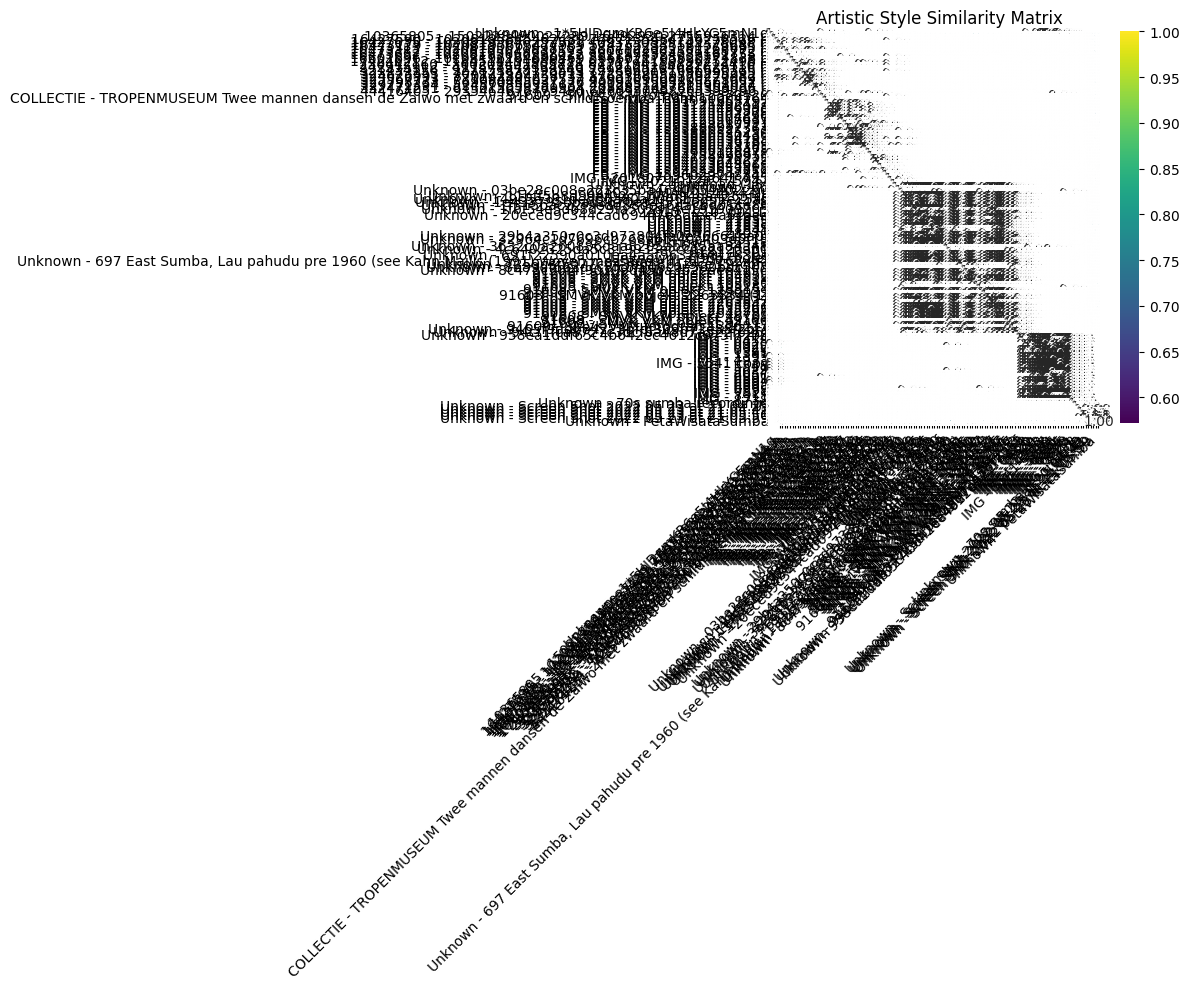

In [7]:
# Create style similarity matrix
similarity_data = create_style_similarity_matrix(artwork_images, style_analyzer)

# Extract data for visualization
similarity_matrix = np.array(similarity_data['similarity_matrix'])
image_ids = similarity_data['image_ids']

# Create labels for the heatmap
labels = [f"{artwork['artist']} - {artwork['title']}" for artwork in artwork_images]

# Plot similarity matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=labels, yticklabels=labels)
plt.title("Artistic Style Similarity Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Visualize Style Embeddings

Let's visualize the style embeddings using dimensionality reduction techniques like t-SNE and UMAP.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


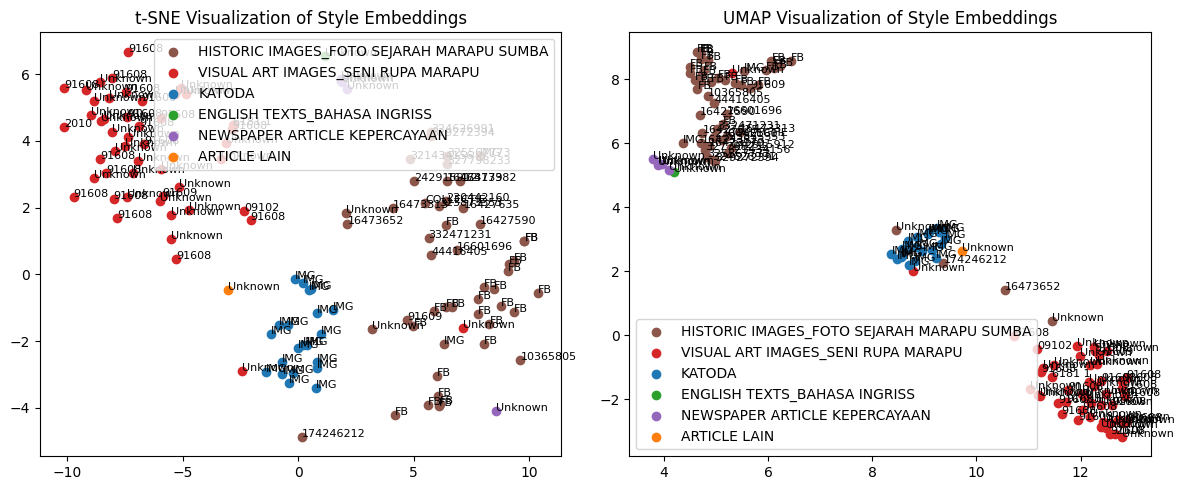

In [8]:
# Extract style embeddings
embeddings = [artwork['style_analysis']['style_embedding'] for artwork in artwork_images]
embeddings_array = np.array(embeddings)

# Create labels and colors for the plot
styles = [artwork['style'] for artwork in artwork_images]
unique_styles = list(set(styles))
style_to_color = {style: plt.cm.tab10(i) for i, style in enumerate(unique_styles)}
colors = [style_to_color[style] for style in styles]

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings_array)

# Reduce dimensionality with UMAP
umap_reducer = umap.UMAP(random_state=42)
umap_result = umap_reducer.fit_transform(embeddings_array)

# Plot t-SNE results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i, (x, y) in enumerate(tsne_result):
    plt.scatter(x, y, color=colors[i], label=styles[i])
    plt.annotate(artwork_images[i]['artist'], (x, y), fontsize=8)
plt.title("t-SNE Visualization of Style Embeddings")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Plot UMAP results
plt.subplot(1, 2, 2)
for i, (x, y) in enumerate(umap_result):
    plt.scatter(x, y, color=colors[i], label=styles[i])
    plt.annotate(artwork_images[i]['artist'], (x, y), fontsize=8)
plt.title("UMAP Visualization of Style Embeddings")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

## 7. Find Similar Artworks

Let's find artworks with similar styles to a query artwork.

Query artwork: 1*5HJDqmKR6e5J4HkYC5mN1g by Unknown (HISTORIC IMAGES_FOTO SEJARAH MARAPU SUMBA)


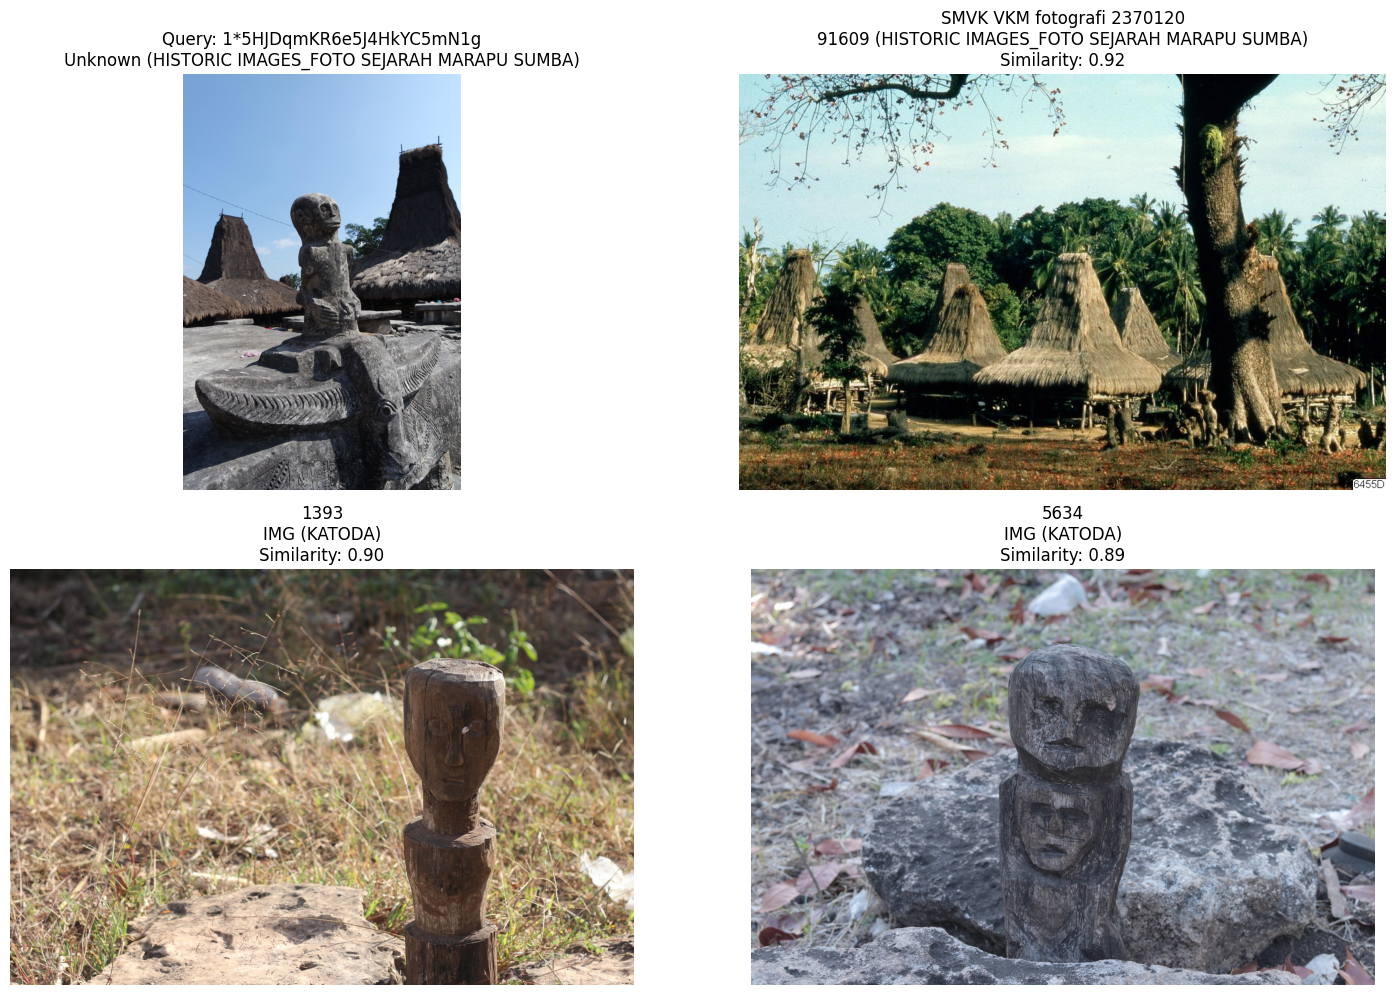

In [9]:
# Select a query artwork (e.g., Van Gogh's Starry Night)
query_idx = 0  # Change this to select a different query artwork
query_artwork = artwork_images[query_idx]

print(f"Query artwork: {query_artwork['title']} by {query_artwork['artist']} ({query_artwork['style']})")

# Find similar artworks
similar_artworks = find_similar_images(query_artwork, artwork_images, style_analyzer, top_k=3)

# Display query artwork
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
query_image = Image.open(query_artwork['image_path'])
plt.imshow(query_image)
plt.title(f"Query: {query_artwork['title']}\n{query_artwork['artist']} ({query_artwork['style']})")
plt.axis('off')

# Display similar artworks
for i, similar in enumerate(similar_artworks):
    plt.subplot(2, 2, i+2)
    similar_image = Image.open(similar['image']['image_path'])
    plt.imshow(similar_image)
    plt.title(f"{similar['image']['title']}\n{similar['image']['artist']} ({similar['image']['style']})\nSimilarity: {similar['similarity']:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 8. Integration with RAG Pipeline

This style analysis component can be integrated into the full multimodal RAG pipeline to enable:

1. **Style-based retrieval**: Find documents or images with similar artistic styles
2. **Style-aware generation**: Generate responses that incorporate knowledge of artistic styles
3. **Cross-modal queries**: Answer questions about artistic styles using both text and image inputs

The style analyzer we've implemented follows the same approach as described in the [Hugging Face cookbook article on analyzing art](https://huggingface.co/learn/cookbook/en/analyzing_art_with_hf_and_fiftyone), but is integrated into our modular RAG pipeline architecture.